In [1]:
import random

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'

from foregrounds_utils import *

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
map_size = 256
n_test = int(1984)
batch_size = 32
learning_rate = 1e-4

# Load selection of synthesized $Q,U$ maps
## (Fewer examples in this demo than in published full version)
## Rescaling target:

$\sigma_E(DUST) = 1.430 \mu K$

$\sigma_B(DUST) = 0.686 \mu K$

$\sigma_E(CMB) = 3.88 \mu K$

$\sigma_B(CMB) = 0.238 \mu K$

In [14]:
directory_synthesis = './data/synth/'
n_step = 4
E_map_std = 1.42964
B_map_std = E_map_std*0.48


# Load synthesized examples and augment
noisy_array = augmented_foreground_generation(directory_synthesis, n_step,
                                              E_map_std, B_map_std, map_size)


1.42964 0.6862272
24
(3072, 256, 256, 2)


In [15]:
clean_array = np.load('./data/cmb/cmb_examples.npy')

In [16]:
clean_array = clean_array[:3072].astype(np.float32)

In [17]:
np.save('./data/cmb/cmb_examples.npy', clean_array)

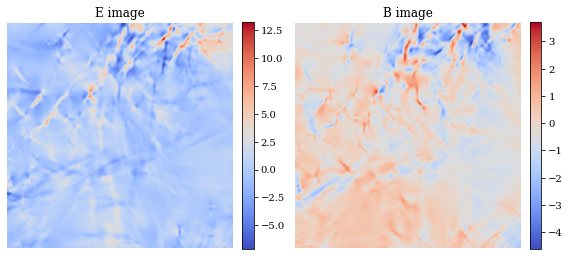

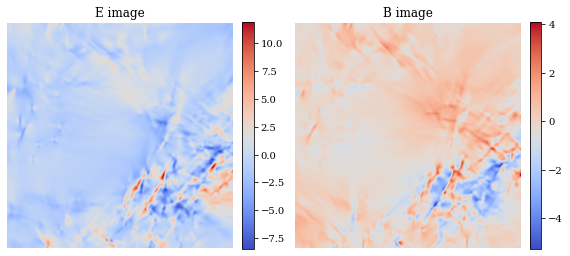

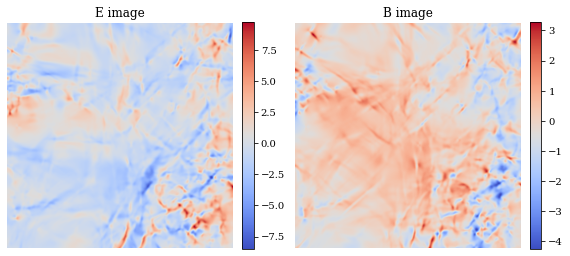

In [7]:
for i in range(3):
    _ = plt.figure(figsize=(8,4))
    _ = plt.subplot(1,2,1), plt.imshow(noisy_array[i,:,:,0],
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('E image'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.subplot(1,2,2), plt.imshow(noisy_array[i,:,:,1],
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('B image'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.tight_layout(True), plt.show()

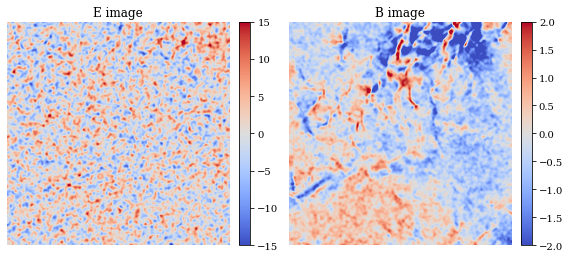

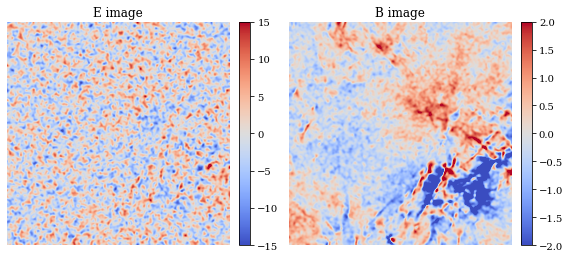

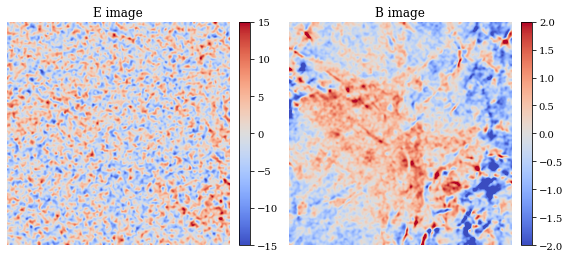

In [8]:
for i in range(3):
    _ = plt.figure(figsize=(8,4))
    _ = plt.subplot(1,2,1), plt.imshow(noisy_array[i,:,:,0] + clean_array[i,:,:,0], clim=(-15,15),
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('E image'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.subplot(1,2,2), plt.imshow(noisy_array[i,:,:,1] + clean_array[i,:,:,1], clim=(-2,2),
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('B image'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.tight_layout(True), plt.show()

## CNN rescaling for network dynamic range

In [9]:
cnn_rescale_E = 57.
cnn_rescale_B = 10.

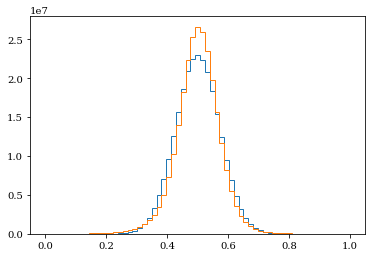

In [10]:
_ = plt.hist((noisy_array[:4000,:,:,0]+clean_array[:4000,:,:,0]).flatten()/cnn_rescale_E+0.5,
             histtype='step', bins=np.linspace(0,1,64))
_ = plt.hist((noisy_array[:4000,:,:,1]+clean_array[:4000,:,:,1]).flatten()/cnn_rescale_B+0.5,
             histtype='step', bins=np.linspace(0,1,64))

In [11]:
# Draw from amplitude prior distribution (add scatter)

for i in range(noisy_array.shape[0]):
    if i%2000==0: print(i)
    noisy_array[i,:,:,0] = noisy_array[i,:,:,0]*np.random.normal(1.,0.044/0.172)
    noisy_array[i,:,:,1] = noisy_array[i,:,:,1]*np.random.normal(1.,0.044/0.172)

noisy_array = noisy_array + clean_array

noisy_array[:,:,:,0] = noisy_array[:,:,:,0]/cnn_rescale_E
clean_array[:,:,:,0] = clean_array[:,:,:,0]/cnn_rescale_E
noisy_array[:,:,:,1] = noisy_array[:,:,:,1]/cnn_rescale_B
clean_array[:,:,:,1] = clean_array[:,:,:,1]/cnn_rescale_B

noisy_array = np.clip(noisy_array, -0.5, 0.5)
clean_array = np.clip(clean_array, -0.5, 0.5)

test_array_noisy = noisy_array[:n_test]
test_array_clean = clean_array[:n_test]
gc.collect()

noisy_array = noisy_array[n_test:]
clean_array = clean_array[n_test:]
gc.collect()

0
2000
4000
6000
8000
10000
12000


0

# Train Moment Network 

## Posterior mean

In [12]:
train_gen = cnn.BatchGenerator(noisy_array+0.5,
                               np.expand_dims(np.atleast_3d(clean_array[:,:,:,1]), axis=3)+0.5,
                               gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy+0.5,
                               np.expand_dims(np.atleast_3d(test_array_clean[:,:,:,1]), axis=3)+0.5,
                              gen_batch_size=batch_size)

cnn_instance = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate, channels=[2,1])
cnn_model = cnn_instance.model()

# cnn_model = keras.models.load_model('./models/mean_QU_E_40/')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 304         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=40,
                         steps_per_epoch=np.ceil(noisy_array.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)), verbose=True)

gc.collect()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

Epoch 1/40


/obs/njeffrey/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


322/322 [==============================] - 27s 72ms/step - loss: 0.0112 - val_loss: 9.1064e-04
Epoch 2/40
322/322 [==============================] - 22s 69ms/step - loss: 8.2931e-04 - val_loss: 6.0495e-04
Epoch 3/40
322/322 [==============================] - 22s 69ms/step - loss: 5.3377e-04 - val_loss: 4.7065e-04
Epoch 4/40
322/322 [==============================] - 25s 78ms/step - loss: 4.5185e-04 - val_loss: 4.1534e-04
Epoch 5/40
322/322 [==============================] - 23s 70ms/step - loss: 4.0975e-04 - val_loss: 3.9329e-04
Epoch 6/40
322/322 [==============================] - 22s 69ms/step - loss: 3.8786e-04 - val_loss: 3.7575e-04
Epoch 7/40
322/322 [==============================] - 22s 70ms/step - loss: 3.7115e-04 - val_loss: 3.7051e-04
Epoch 8/40
322/322 [==============================] - 22s 70ms/step - loss: 3.5801e-04 - val_loss: 3.5642e-04
Epoch 9/40
322/322 [==============================] - 22s 69ms/step - loss: 3.4947e-04 - val_loss: 3.5480e-04
Epoch 10/40
322/322 [====

KeyboardInterrupt: 

In [ ]:
cnn_model.save('./models/demo_mean')

In [ ]:
test_output = cnn_model.predict(test_array_noisy[:5,:,:]+0.5)

In [ ]:
_ = plt.figure(figsize=(9,9))
_ = plt.subplot(221), plt.imshow(test_array_noisy[0,:,:,1]+0.5, clim=(0.2,0.8)), plt.colorbar()
_ = plt.subplot(222), plt.imshow(test_output[0,:,:,0], clim=(0.44,0.56)), plt.colorbar()
_ = plt.subplot(223), plt.imshow(test_array_clean[0,:,:,1]+0.5, clim=(0.4,0.6)), plt.colorbar()
_ = plt.subplot(224), plt.imshow((test_array_clean[0,:,:,1]+0.5-test_output[0,:,:,0]+0.5), clim=(0.4,0.6))
_ = plt.colorbar()

## Posterior variance

In [ ]:
E_or_B = 1
t = time.time()
predict_batch = 400
n_predict_batches = np.ceil(noisy_array.shape[0]/predict_batch).astype(int)
print(n_predict_batches)
target_var = np.vstack([cnn_model.predict(0.5+noisy_array[i*predict_batch:(i+1)*predict_batch]) 
                        for i in range(n_predict_batches)])

print(time.time() - t, flush=True)
target_var = 100*(target_var - np.expand_dims(np.atleast_3d(clean_array[:,:,:,E_or_B]), axis=3) - 0.5)**2.

train_gen_var = cnn.BatchGenerator(noisy_array[n_test:]+0.5,
                                   target_var[n_test:],
                                   gen_batch_size=batch_size)
test_gen_var = cnn.BatchGenerator(noisy_array[:n_test]+0.5,
                                  target_var[:n_test],
                                  gen_batch_size=batch_size)

cnn_instance_var = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate, channels=[2,1])
cnn_model_var = cnn_instance_var.model()

print('Train variance', flush=True)


history_var = cnn_model_var.fit_generator(generator=train_gen_var,
                         epochs=10,
                         steps_per_epoch=np.ceil(noisy_array[n_test:].shape[0] / int(batch_size)),
                         validation_data=test_gen_var,
                         validation_steps=np.ceil(noisy_array[:n_test].shape[0] / int(batch_size)))

In [ ]:
cnn_model_var.save('./models/demo_var')

In [ ]:
plt.plot(history_var.history['loss'])
plt.plot(history_var.history['val_loss'])
plt.yscale('log')

# Validation with independent simulation

In [ ]:
validation_data = np.load('./data/sim/validation_sim.npy')
clean_validation_data = validation_data[1]
validation_data = validation_data[0]

In [ ]:
mean_test = cnn_model_mean_demo(validation_data+0.5)

In [ ]:
var_test = cnn_model_var_demo(validation_data+0.5)/100.

In [ ]:
x=np.linspace(-6.5,6.5,512)
for i in range(4):
    samples_normal_temp = (mean_test[i,:,:,0]-0.5-clean_validation_data[i,:,:,1])/np.sqrt(var_test[i,:,:,0])
    print(np.std(samples_normal_temp), np.mean(samples_normal_temp))
    _ = plt.hist(samples_normal_temp, bins=np.linspace(-6.5,6.5,64), color='C2', density=True, alpha=0.5,label=r'$( \mu_B - s_B ) / \sigma_B$')
    _ = plt.plot(x, stats.norm.pdf(x, 0, 1),'--', label='Normal (target)')
    _ = plt.legend(fontsize=12.), plt.show()